=== Disaster Visual Summarization Pipeline (Enhanced) ===

--- Extracting Frame Features ---
Feature Matrix Shape: (10, 4)

       🧠 Disaster Visual Summarization Output
Total Post-Disaster Frames Processed: 10
Number of Key Frames Selected (S_key): 3
Indices of Key Frames: [np.int64(0), np.int64(1), np.int64(4)]



/tmp/ipython-input-2934033141.py:117: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout() # Adjust layout
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


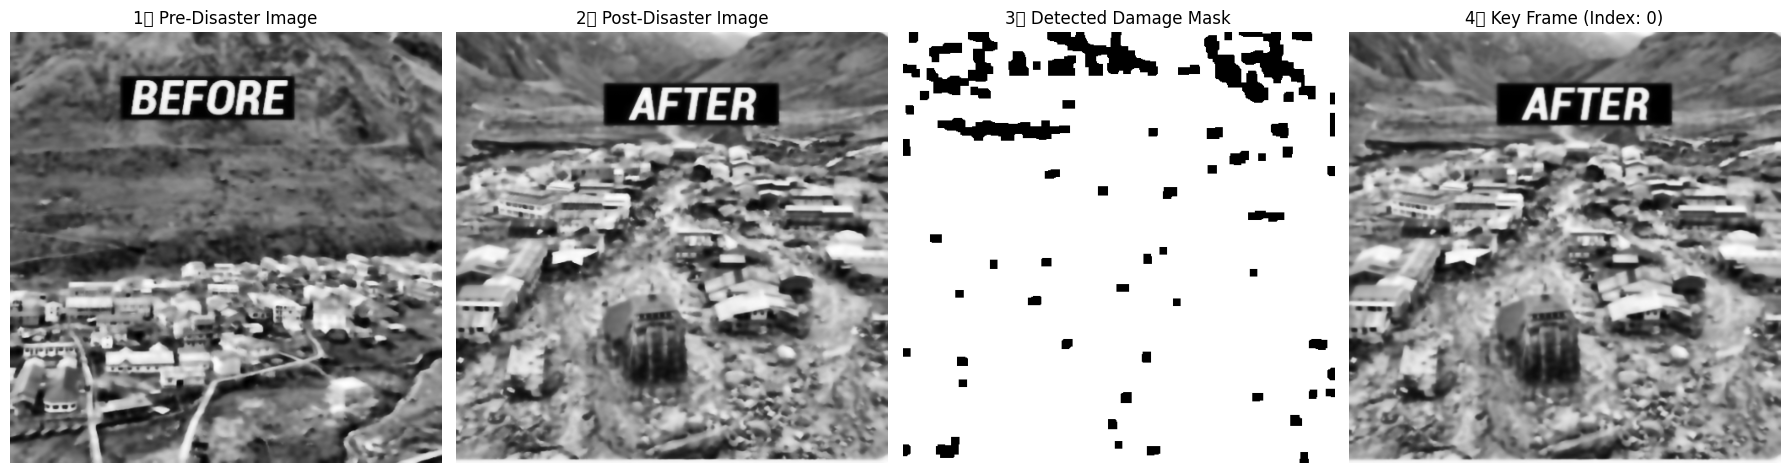

✅ Saved Example Key Frame to: /content/key_frame_summary_enhanced.jpg


In [ ]:
#  ENHANCED VISUAL SUMMARIZATION PIPELINE
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix, graycoprops
import os

# 1️ Image Preprocessing Function
def preprocess_image(img):
    """Enhance contrast, reduce noise, and resize image."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE for local contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Denoise while preserving edges
    denoised = cv2.bilateralFilter(enhanced, 9, 75, 75)

    # Resize to standard size (optional)
    resized = cv2.resize(denoised, (512, 512))
    return resized

# 2️ Damage Segmentation (Simple Version)

def detect_damage(pre_img, post_img):
    """Compute absolute difference mask to detect damaged regions."""
    diff = cv2.absdiff(post_img, pre_img)

    # Threshold to highlight large changes
    _, mask = cv2.threshold(diff, 30, 255, cv2.THRESH_BINARY)

    # Morphological cleanup
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    return mask

# 3️ Feature Extraction (ORB + Texture)
def extract_features(image):
    """Extract ORB keypoints + texture features."""
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    num_keypoints = len(keypoints)

    # Ensure image is uint8 for GLCM
    img_uint8 = image.astype(np.uint8)

    # Texture features using GLCM
    # Adjusting distances and angles for GLCM to handle potential small images or simpler textures
    distances = [1] # Consider only adjacent pixels
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 0, 45, 90, 135 degrees

    glcm = graycomatrix(img_uint8, distances, angles, levels=256, symmetric=True, normed=True)

    # Ensure glcm is not empty before calculating properties
    if glcm.size == 0:
        # Return default values or handle appropriately
        return [num_keypoints, 0.0, 1.0, 0.0] # Default values for contrast, homogeneity, energy

    contrast = graycoprops(glcm, 'contrast').mean() # Use mean if multiple angles
    homogeneity = graycoprops(glcm, 'homogeneity').mean()
    energy = graycoprops(glcm, 'energy').mean()


    return [num_keypoints, contrast, homogeneity, energy]


# 4️ Key Frame Summarization (Feature Clustering)
def summarize_frames(features, n_clusters=3):
    """Cluster feature vectors to select key frames."""
    # Ensure there are enough samples for clustering
    if len(features) < n_clusters:
        print(f"Warning: Not enough frames ({len(features)}) for {n_clusters} clusters. Selecting all frames.")
        return list(range(len(features)))

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Add n_init for newer KMeans versions
    kmeans.fit(features)
    centers = kmeans.cluster_centers_

    key_indices = []
    for center in centers:
        distances = np.linalg.norm(features - center, axis=1)
        key_indices.append(np.argmin(distances))
    return sorted(list(set(key_indices)))

# 5️ Visualization Function

def visualize_results(pre, post, mask, key_indices, post_frames):
    plt.figure(figsize=(18, 6)) # Increased figure size

    plt.subplot(1, 4, 1) # Added a slot for the original post image
    plt.imshow(pre, cmap='gray')
    plt.title("1️⃣ Pre-Disaster Image")
    plt.axis('off') # Turn off axes

    plt.subplot(1, 4, 2)
    plt.imshow(post, cmap='gray')
    plt.title("2️⃣ Post-Disaster Image")
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("3️⃣ Detected Damage Mask")
    plt.axis('off')

    # Display multiple key frames if available
    for i, idx in enumerate(key_indices[:1]): # Display only the first key frame for simplicity
        plt.subplot(1, 4, 4)
        plt.imshow(post_frames[idx], cmap='gray')
        plt.title(f"4️⃣ Key Frame (Index: {idx})")
        plt.axis('off')


    plt.tight_layout() # Adjust layout
    plt.show()

# 6️ Main Execution
# ------------------------------------------------
print("=== Disaster Visual Summarization Pipeline (Enhanced) ===")

# Load images
pre_path = "/content/pre.jpg"
post_path = "/content/post.jpg"

# --- Placeholder image creation (REMOVE THIS and uncomment the lines below once you upload your images) ---
# print("Creating placeholder images for demonstration...")
# # Create a simple pre-disaster image (e.g., a solid gray image)
# pre_img_raw = np.full((512, 512, 3), 150, dtype=np.uint8)
# cv2.imwrite(pre_path, pre_img_raw)

# # Create a simple post-disaster image with a damaged area (e.g., a darker rectangle)
# post_img_raw = np.copy(pre_img_raw)
# cv2.rectangle(post_img_raw, (100, 100), (400, 400), (50, 50, 50), -1) # Draw a dark rectangle
# cv2.imwrite(post_path, post_img_raw)
# print("Placeholder images created.")
# ----------------------------------------------------------------------------------------------------------


# Uncomment these lines to load your actual images after uploading them
pre_img_raw = cv2.imread(pre_path)
post_img_raw = cv2.imread(post_path)


if pre_img_raw is None or post_img_raw is None:
    # This check will now pass if placeholder images are created
    raise FileNotFoundError("❌ Pre/Post disaster images not found. Upload pre.jpg and post.jpg to /content")

# Step 1: Preprocess
pre_img = preprocess_image(pre_img_raw)
post_img = preprocess_image(post_img_raw)

# Step 2: Generate mock frames (simulate post-disaster sequence)
# Creating slightly different frames to allow for feature variation
post_frames = [cv2.GaussianBlur(post_img, (5,5), i/2.0) for i in range(1, 11)] # Vary sigma for more distinct frames

# Step 3: Damage detection
damage_mask = detect_damage(pre_img, post_img)

# Step 4: Extract features for each frame
print("\n--- Extracting Frame Features ---")
features = np.array([extract_features(f) for f in post_frames])
print("Feature Matrix Shape:", features.shape)

# Step 5: Summarize (Key Frame Selection)
n_clusters_to_select = min(3, len(post_frames)) # Ensure n_clusters doesn't exceed the number of frames
key_indices = summarize_frames(features, n_clusters=n_clusters_to_select)


print("\n=======================================================")
print("       🧠 Disaster Visual Summarization Output")
print("=======================================================")
print(f"Total Post-Disaster Frames Processed: {len(post_frames)}")
print(f"Number of Key Frames Selected (S_key): {len(key_indices)}")
print(f"Indices of Key Frames: {key_indices}")
print("=======================================================\n")

# Step 6: Visualization
# Pass original post_img_raw for visualization alongside pre_img and mask
visualize_results(pre_img, post_img, damage_mask, key_indices, post_frames)

# Save one key frame
if key_indices: # Check if key_indices is not empty
    key_frame = post_frames[key_indices[0]]
    save_path = "/content/key_frame_summary_enhanced.jpg"
    cv2.imwrite(save_path, key_frame)
    print(f"✅ Saved Example Key Frame to: {save_path}")
else:
    print("⚠️ No key frames selected to save.")